In [200]:

import torch
import numpy as np
import os

from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as T

import matplotlib.pyplot as plt
import pandas as pd

from numpy import genfromtxt

from PIL import Image

import random

# import visiondataset
from torchvision.datasets import VisionDataset

In [201]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [202]:

from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim 
import torch.nn as nn


import torch.nn.functional as F

from torch.autograd import Variable

from fastai.vision.all import *
from fastai.vision.gan import *

from fastai.callback.all import *

In [203]:
from datasets import load_dataset, Split

In [204]:
import torch.autograd as autograd

In [205]:
channels = 3 ## 1 for B&W, 3 for RGB, 4 for RGBA

learning_rate    = 2e-4#0.003  ## Adam default   ## 0.001 2e-4#
batch_size       = 64
N_Epochs         = 4_000  ##27000  
num_classes = 3
pixels = 16
img_size = pixels*pixels*channels
certainty_repeater = 6# channels**2 - num_classes
print(f"{img_size=}")

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps is not None:
    device = torch.device('mps')
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
else:
    device = torch.device('cpu')
    # print a warning that cpu is being used
    print("Warning: Running on CPU. This will be slow.")
print(f"{device=}")
device = 'cpu'

img_size=768
device=device(type='mps')


In [206]:
import pickle
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

class MyDataset(VisionDataset):
    classes = [
        'sword',
        'pickaxe',
        'axe',
        'hoe',
        'shovel'
    ]

    def __init__(
        self,
        root: str = "mc-dataset.pkl",
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.train = train  # training set or test set

        self.data, self.targets = self._load_data()

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        # img = Image.fromarray(img.numpy().astype(np.uint8))

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self) -> int:
        return len(self.data)
    
    def _load_data(self):
        with open('mc-dataset.pkl', 'rb') as f:
            data = pickle.load(f)
        
        imgs = []
        labels = []
        for i in range(len(data)):
            imgs.append(torch.Tensor(data[i][0]))
            labels.append(data[i][1])

        # if self.train:
        #     data = data[0]
        # else:
        #     data = data[1]
        return imgs, labels

img.shape=torch.Size([16, 16, 3])


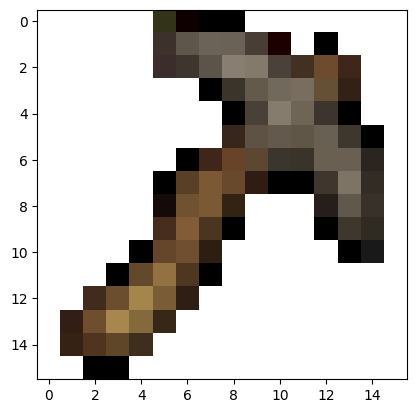

In [207]:
# df = pd.DataFrame(dataset.reshape((dataset.shape[0], 32*32)))
# df.to_csv(f"{data}-dataset.csv", index=False, header=False)

# load the dataset
dataset = MyDataset()

# load the first image in the dataset
# print(dataset[5][0])
img, label = dataset[5]
print(f"{img.shape=}")
img *= 255
plt.imshow(Image.fromarray(img.numpy().astype(np.uint8)))

In [208]:
# display the split of labels in the dataset
for i in range(5):
    print(f"Label {i}: {len([x for x in dataset.targets if x == i])}")

# convert the dataset into a train / test split
# TODO i dont think test is used
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.95, 0.05])

# define the dataloader
dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Label 0: 144
Label 1: 107
Label 2: 103
Label 3: 0
Label 4: 0


In [209]:

def plot_GAN_losses(list_losses_real, list_losses_fake, list_losses_tricked):
    
    the_epochs = [i for i in range(len(list_losses_real))]  

    plt.plot(the_epochs, list_losses_real,    label = "real") 
    plt.plot(the_epochs, list_losses_fake,    label = "fake") 
    plt.plot(the_epochs, list_losses_tricked, label = "tricked")
    plt.legend() 
    plt.show()


In [210]:

def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    print('F1-mesure: %.3f' % f1_measure)
    return f1_measure, confmat


In [211]:
def plot_metric_per_epoch(the_scores_list):
    x_epochs = []
    y_epochs = [] 
    for i, val in enumerate(the_scores_list):
        x_epochs.append(i)
        y_epochs.append(val)
    
    plt.scatter(x_epochs, y_epochs,s=50,c='lightgreen', marker='s', label='score')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Score per epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [212]:
def random_G_vector_input():
    rand_vec = torch.randn( 100 ).to(device)
    return rand_vec

In [213]:
def random_G_batch_vector_input():
    rand_vec = torch.randn( (batch_size, 100 ) ).to(device)
    return rand_vec

In [214]:
def random_batch_one_hot_rc(batch_size, size):
    rand_vec = torch.zeros( (batch_size, num_classes ) ).to(device)
    for i in range(batch_size):
        random_idx = random.randint(0,size-1)
        rand_vec[i, random_idx] = 1.0
    return rand_vec

In [215]:

class Generator_Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        

        self.linear1 = nn.Linear(100+num_classes*certainty_repeater, 256)
        self.act1    = nn.LeakyReLU(0.02)
        self.norm1   = nn.LayerNorm(256)
        self.linear2 = nn.Linear(256, img_size)
        self.act2    = nn.Sigmoid()
        self.dropout = nn.Dropout(0.25)
        

    def forward(self, rand_input ):
        
        ## print(rand_input.shape)
        ## print(label_tensor.shape)

        # print(f"gen: forward: {rand_input.shape=}, {label_tensor.shape=}")

        x      = self.linear1( rand_input )
        x      = self.act1(x)
        x      = self.norm1(x) 
        x      = self.linear2(x)
        x      = self.act2(x)
        y_pred = x
        
        return y_pred


In [216]:

class Generator_DL_Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        

        self.linear1 = nn.Linear(100, 60)
        self.act1    = nn.LeakyReLU(0.02)
        self.norm1   = nn.LayerNorm(60)
        self.linear2 = nn.Linear(60, 120)
        self.act2    = nn.LeakyReLU(0.02)
        self.norm2   = nn.LayerNorm(120)
        self.linear3 = nn.Linear(120, img_size)
        self.act3    = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, rand_input ):
        

        x      = self.linear1( rand_input )
        x      = self.act1(x)
        x      = self.norm1(x) 
        x      = self.dropout(x)
        x      = self.linear2(x)
        x      = self.act2(x)
        x      = self.norm2(x) 
        x      = self.dropout(x)
        x      = self.linear3(x)
        x      = self.act3(x)
        
        y_pred = x
        
        return y_pred


In [217]:

class Discriminator_Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # self.linear1 = nn.Linear(img_size+num_classes, 100)
        self.linear1 = nn.Linear(img_size+num_classes*certainty_repeater, 100)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(100, 50)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(50, 1)
        self.act3    = nn.Sigmoid()             ## nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.25)
        

    def forward(self, x):
        
        # print(f"disc: forward: {x.shape=}, {label_tensor.shape=}")
        # inputs = torch.cat( (x, label_tensor) , dim=1)
        inputs = x
        
        # print(inputs)
        x      = self.linear1( inputs )
        # print(x)
        x      = self.act1(x)
        x      = self.dropout(x)
        # print(x)
        x      = self.linear2(x)
        x      = self.act2(x)
        # print(x)
        x      = self.dropout(x)
        x      = self.linear3(x)
        y_pred = self.act3(x)
        # print(y_pred)
        
        return y_pred


In [218]:
list_losses_real    = []
list_losses_fake    = []
list_losses_tricked = []

classes = [
    'sword',
    'pickaxe',
    'axe',
    'hoe',
    'shovel'
]

import tqdm

def training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt   ):
    pbar = tqdm.tqdm(range(N_Epochs+1))

    for epoch in pbar:
        # shuffle dl_train every epoch
        dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        for xb, yb in dl_train:              ## xb = [batch, 1, 28, 28]
            xb, yb = xb.to(device), yb.to(device)

            # TODO skip if not enough data
            if xb.shape[0] != batch_size:
                # print(f"skipping batch of size {xb.shape[0]}")
                continue

            if channels == 4 or channels == 3:
                xb = xb.permute(0, 3, 1, 2)
            # xb = xb.permute(0, 1, 2)
            # print('xb: before:', xb.shape)
            # xb = torch.permute(xb, (0, 3, 2, 1))
            # xb = torch.permute(xb, (0, ))
            xb = torch.squeeze(xb, dim=1)
            # print('xb:', xb.shape)
            # print('xb:', xb.shape)
            xb = xb.reshape((-1, img_size))
            
            ## yb_one_hot = func( yb )
            # print('xb: after:', xb.shape)
            yb = F.one_hot(yb, num_classes=num_classes)
            yb = yb.repeat(1, certainty_repeater)
            ## print( yb.shape )
            ## input()
       
            #################################################
            
            ## G_model.eval()     ## No G training
            
            ## gen_img = G_model( random_G_vector_input() )
            
            rand_vector = random_batch_one_hot_rc(batch_size, num_classes)
            rand_vector = rand_vector.repeat(1, certainty_repeater)
            inputs = torch.cat( (random_G_batch_vector_input(), rand_vector) , dim=1)
            
            # TODO this seems to work fine
            # gen_img = G_model( random_G_batch_vector_input(),  rand_vector ).detach()
            gen_img = G_model( inputs ).detach()
        
            ## gen_labels = random_batch_one_hot(32, 10)
            
            # convert yb to 3d ohe
            # print(f"{yb.shape=}")
            # yb = yb.repeat(4, 32, 1, 1).permute(2, 0, 1, 3) # [ batch, x (classes), y, channels ]
            # print(f"{yb.shape=}")
            ## Train D with real data
            # set channel 4 of yb to 1
            # yb[:, 3, :, :] = 1
            # yb = (1-yb)*255
            # print(yb[0])
            # inputs = torch.cat( (xb, yb) , dim=3)
            inputs = torch.cat( (xb, yb) , dim=1)
            real_data = inputs
            # print(f"{inputs.shape=}")

            # temporarily convert to inputs to an image and dispaly it
            # print(inputs[0].shape)
            # plt.imshow(inputs[0].permute(1, 2, 0))

            D_real_y_pred = D_model( inputs  )
            # print(D_real_y_pred)
            # TODO check these line up with labels
            D_real_loss   = D_loss_fn( D_real_y_pred, torch.ones((batch_size, 1)).to(device) )
            # D_real_loss   = D_loss_fn(D_model, inputs, real_data,  D_real_y_pred, torch.ones((batch_size, 1)).to(device) )
            D_opt.zero_grad()
            D_real_loss.backward()
            D_opt.step()
            # print(D_real_y_pred)
            # break
            
            ## Train D with fake data
            # rand_vector = rand_vector.repeat(4, 32, 1, 1).permute(2, 0, 1, 3)
            # inputs = torch.cat( (gen_img, rand_vector) , dim=3)
            # print(f"before: {gen_img.shape=}")
            gen_img = gen_img.reshape((-1, img_size))
            # print(f"after: {gen_img.shape=}")
            # print(img_size)
            inputs = torch.cat( (gen_img, rand_vector) , dim=1)
            D_fake_y_pred = D_model(  inputs  )
            D_fake_loss   = D_loss_fn( D_fake_y_pred, torch.zeros((batch_size, 1)).to(device))
            # D_fake_loss   = D_loss_fn(D_model, inputs, real_data, D_fake_y_pred, torch.zeros((batch_size, 1)).to(device))
            # G_fake_loss = D_fake_y_pred.mean()
            D_opt.zero_grad()
            # G_opt.zero_grad()
            D_fake_loss.backward()
            # G_fake_loss.backward()
            D_opt.step()
            # G_opt.step()
            
            ## G_model.train()    ## yes G training
            
            #################################################
            
            ## D_model.eval()     ## No D training
            
            ## gen_img = G_model( random_G_vector_input() )
            
            rand_vector = random_batch_one_hot_rc(batch_size, num_classes)
            rand_vector = rand_vector.repeat(1, certainty_repeater)
            
            inputs = torch.cat( (random_G_batch_vector_input(), rand_vector) , dim=1)
            gen_img = G_model( inputs )
            
            
            ## Train G with D_loss (need to trick D)
            # rand_vector = rand_vector.repeat(4, 32, 1, 1).permute(2, 0, 1, 3)
            gen_img = gen_img.reshape((-1, img_size))
            inputs = torch.cat( (gen_img, rand_vector) , dim=1)
            D_tricked_y_pred = D_model(  inputs  )
            D_tricked_loss   = D_loss_fn( D_tricked_y_pred, torch.ones((batch_size, 1)).to(device) )
            # D_tricked_loss   = D_loss_fn( D_model, inputs, real_data, D_tricked_y_pred, torch.ones((batch_size, 1)).to(device) )
            G_opt.zero_grad()
            D_tricked_loss.backward()
            G_opt.step()
            # break
            
            ## D_model.train()    ## yes D training
        # break                
       
            
        if epoch % 10 == 0:
            # print("******************************")
            # print(epoch, "D_real_loss=", D_real_loss)
            # print(epoch, "D_fake_loss=", D_fake_loss)
            # print(epoch, "D_tricked_loss=", D_tricked_loss)
            list_losses_real.append(        D_real_loss.cpu().detach().numpy()  )
            list_losses_fake.append(        D_fake_loss.cpu().detach().numpy()  )
            list_losses_tricked.append(  D_tricked_loss.cpu().detach().numpy()  )

            # convert losses to numbers rounded to 3 decimal places
            D_real_loss_rnd = np.round(D_real_loss.cpu().detach().numpy(), 3)
            D_fake_loss_rnd = np.round(D_fake_loss.cpu().detach().numpy(), 3)
            D_tricked_loss_rnd = np.round(D_tricked_loss.cpu().detach().numpy(), 3)

            # if the equal sign is not there, it will not round to 3 decimal places
            message = f"{D_real_loss_rnd=}; {D_fake_loss_rnd=}; {D_tricked_loss_rnd=}"
            pbar.set_description(message)
            
        # draw an image of each class
        # place them all on the same figure
        if epoch % 1000 == 0:
            f, axarr = plt.subplots(nrows=1, ncols=num_classes, figsize=(12,4))
            
            for i in range(num_classes):
                # TODO just batch this
                # TODO what is [batch, 100] + [1, labels]
                # rand_vector = random_batch_one_hot_rc(batch_size, num_classes) # lol, it wasnt doing classes
                # rand_vector = rand_vector.repeat(1, certainty_repeater)
                label = torch.tensor([i]).to(device)
                label = F.one_hot(label, num_classes=num_classes)
                label = label.repeat(1, certainty_repeater)

                # inputs = torch.cat( (random_G_batch_vector_input(), label) , dim=1) # it must only get the first one or something
                # create noise and make it 2d
                noise = random_G_vector_input().unsqueeze(0)
                inputs = torch.cat( (noise, label) , dim=1)
                output = G_model( inputs ).cpu()
                # convert output (batch, img_size) to (batch, 4, 32, 32)
                if channels == 4 or channels == 3:
                    # output = output.reshape((-1, 4, pixels, pixels)) # wrong too, lol
                    output = output.reshape((-1, channels, pixels, pixels))
                    # output = output.reshape((-1, 32, 32))

                    img = output.permute(0, 2, 3, 1).detach().numpy()#.reshape(32,32)
                elif channels == 1:
                    img = output.detach().numpy()#.reshape(32,32)
                # print(img.shape)
                # convert img to pil

                if channels == 4 or channels == 3:
                    mode = None
                elif channels == 1:
                    mode = 'L'

                img = Image.fromarray((img * 255).astype(np.uint8)[0], mode=mode)
                # display the image
                axarr[i].imshow(img)
                # place name of class on image
                axarr[i].set_title(classes[i])
            plt.show()
            


In [219]:
for xb, yb in dl_train:
    print(xb.shape, yb.shape)

    b = xb.permute(0, 3, 1, 2)
    # print('xb: before:', xb.shape)
    # xb = torch.permute(xb, (0, 3, 2, 1))
    # xb = torch.permute(xb, (0, ))
    xb = torch.squeeze(xb, dim=1)
    # print('xb:', xb.shape)
    xb = xb.reshape((-1, img_size))
    
    ## yb_one_hot = func( yb )
    # print('xb: after:', xb.shape)
    yb = F.one_hot(yb, num_classes=num_classes)

    inputs = torch.cat( (xb, yb) , dim=1)

    D_real_y_pred = D_model( inputs  )
    correct = {
        'sword': {
            'correct': 0,
            'wrong': 0
        },
        'pickaxe': {
            'correct': 0,
            'wrong': 0
        }
    }
    for pred, label in zip(D_real_y_pred, yb):
        print(pred, label)
        if pred[0] > 0.5:
            if label[0] == 1:
                correct['sword']['correct'] += 1
            else:
                correct['sword']['wrong'] += 1
        else:
            if label[0] == 0:
                correct['pickaxe']['correct'] += 1
            else:
                correct['pickaxe']['wrong'] += 1
    D_real_loss   = D_loss_fn( D_real_y_pred, torch.ones((batch_size, 1)) )
    print(D_real_loss)
    print(correct)

    break

torch.Size([64, 16, 16, 3]) torch.Size([64])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x771 and 786x100)

In [ ]:
LAMBDA = 10
def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(batch_size, 1).to(device)
    alpha = alpha.expand(real_data.size())

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

In [ ]:
def wasserstein_loss(D_model, gen_img, real_data, real_pred, fake_pred):
    # with torch.GradientTape(persistant=True) as tape:

    # grads = tape.gradient(fake_pred, fake_img)
    # grad_norms = grads.norm(2, dim=1)
    # grad_penalty = ((grad_norms - 1) ** 2).mean()

    loss = fake_pred.mean() - real_pred.mean() + calc_gradient_penalty(D_model, real_data, gen_img)
    return loss

D_real_loss_rnd=0.541; D_fake_loss_rnd=0.688; D_tricked_loss_rnd=0.71:   0%|          | 0/4001 [00:00<?, ?it/s]/var/folders/8v/kyhpjx6d3y1b7dp0twz_83sw0000gn/T/ipykernel_8547/1356261966.py:197: RuntimeWarning: invalid value encountered in cast
  img = Image.fromarray((img * 255).astype(np.uint8)[0], mode=mode)


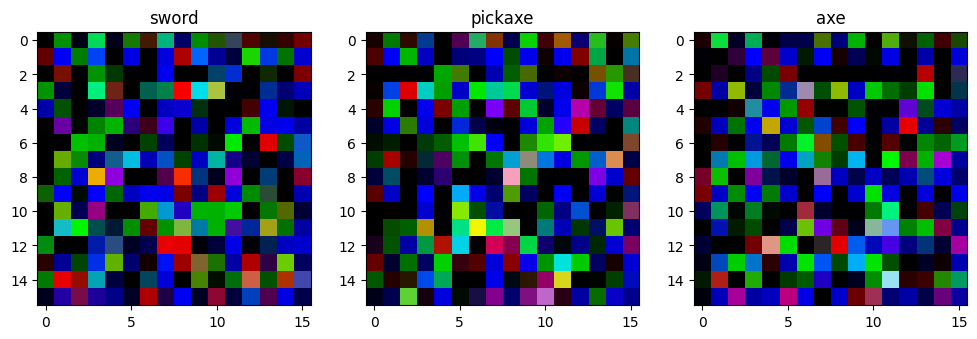

D_real_loss_rnd=0.521; D_fake_loss_rnd=0.552; D_tricked_loss_rnd=1.075:  25%|██▍       | 1000/4001 [02:06<06:24,  7.80it/s]

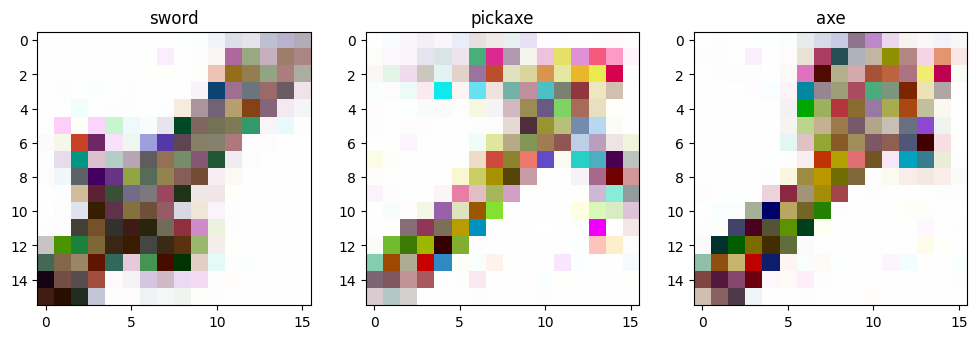

D_real_loss_rnd=0.464; D_fake_loss_rnd=0.563; D_tricked_loss_rnd=1.187:  50%|████▉     | 2000/4001 [04:13<04:14,  7.86it/s]

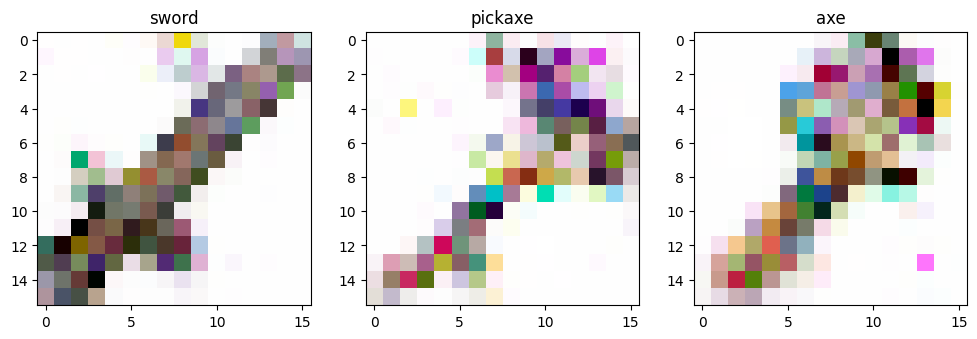

D_real_loss_rnd=0.475; D_fake_loss_rnd=0.734; D_tricked_loss_rnd=0.809:  75%|███████▍  | 3000/4001 [06:20<02:03,  8.11it/s]

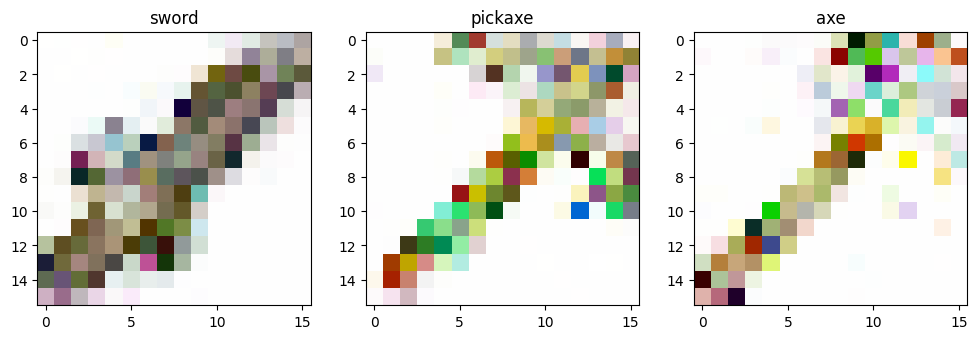

D_real_loss_rnd=0.733; D_fake_loss_rnd=0.679; D_tricked_loss_rnd=0.699: 100%|█████████▉| 4000/4001 [08:26<00:00,  8.10it/s]

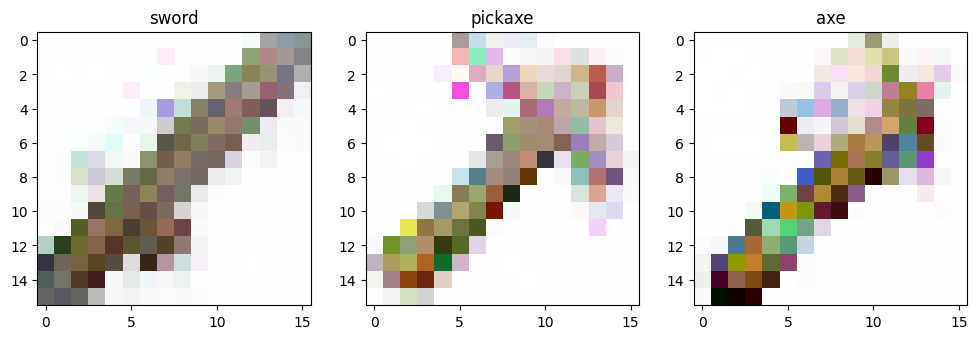

D_real_loss_rnd=0.733; D_fake_loss_rnd=0.679; D_tricked_loss_rnd=0.699: 100%|██████████| 4001/4001 [08:26<00:00,  7.89it/s]


In [220]:
def _tk_mean(fake_pred): return fake_pred.mean() # generator loss
def _tk_diff(real_pred, fake_pred): return real_pred.mean() - fake_pred.mean() # discriminator loss

# G_model    =  Generator_Net()
G_model     =  basic_generator(pixels, in_sz=100+num_classes*certainty_repeater, n_channels=channels, n_extra_layers=1)# Generator_Net()

# G_model     = Generator_DL_Net()

# D_model     =    basic_critic(
#                     32, 
#                     n_channels=4, 
#                     n_extra_layers=1, 
#                     act_cls=partial(  nn.LeakyReLU, negative_slope=0.2)
# )#

D_model = Discriminator_Net() # TODO chagne to not use sigmoid

## D_loss_fn   = nn.CrossEntropyLoss( )  
## D_loss_fn   = F.mse_loss

D_loss_fn   = nn.BCELoss()
# D_loss_fn = wasserstein_loss
# use a loss function that supports values between -1 and 1
# D_loss_fn = nn.BCEWithLogitsLoss()

G_opt       = torch.optim.Adam( G_model.parameters(), lr=learning_rate )
D_opt       = torch.optim.Adam( D_model.parameters(), lr=learning_rate )

# move everything to device
G_model.to(device)
D_model.to(device)
# D_loss_fn.to(device)

training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt )


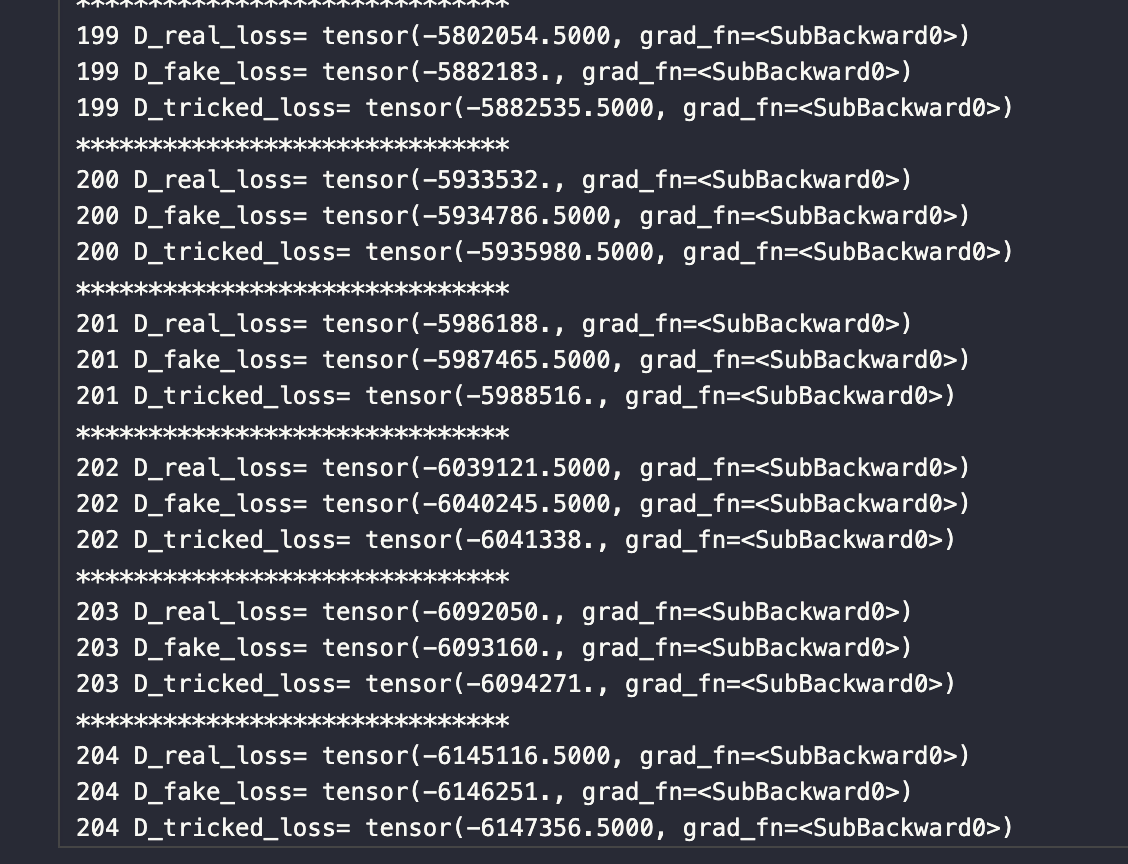

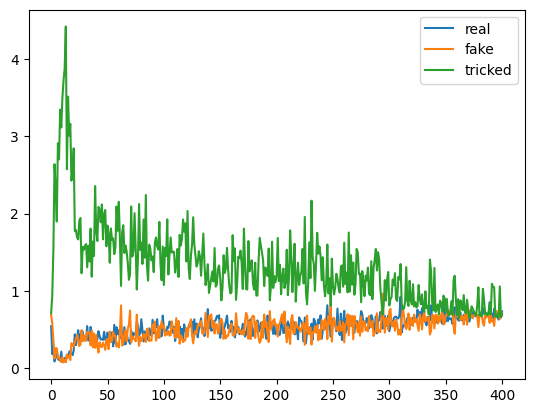

In [221]:
plot_GAN_losses(list_losses_real, list_losses_fake, list_losses_tricked)


In [222]:

label = 0
        
label_tensor = torch.zeros((num_classes)).to(device)
label_tensor[label] = 1.0
        
label_tensor = label_tensor.unsqueeze(0)
label_tensor = label_tensor.repeat(1, certainty_repeater)
print(label_tensor.shape)

# label_tensor = label_tensor.repeat(4, 32, 1).permute(0, 1, 2)
# label_tensor.shape

torch.Size([1, 18])


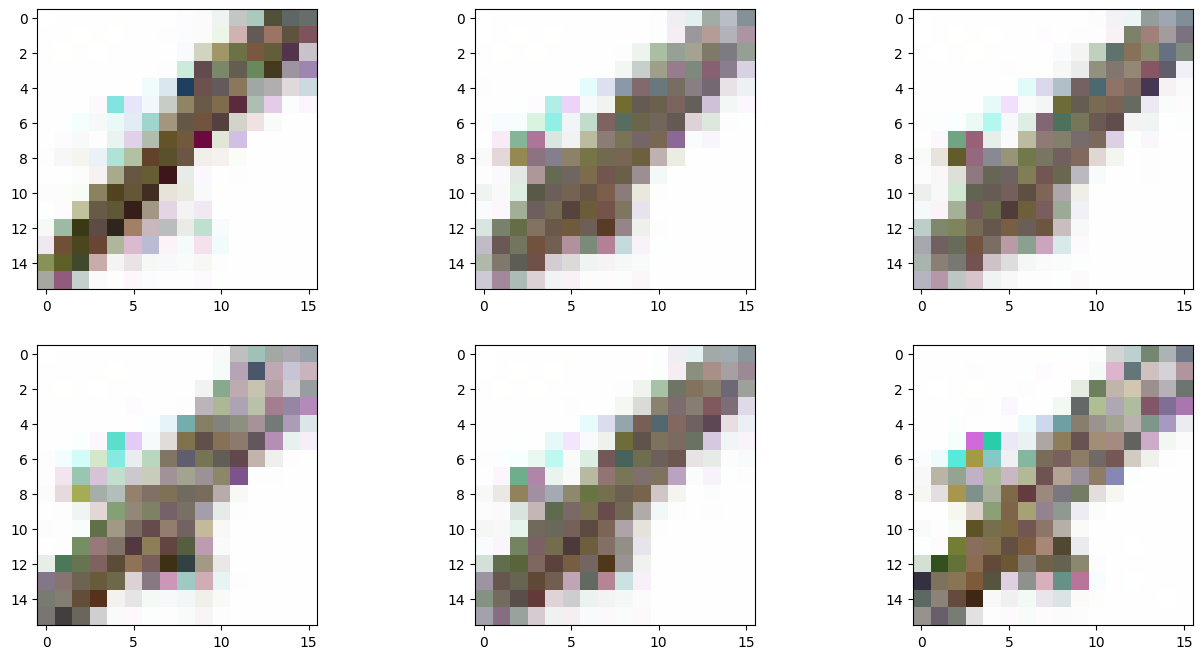

In [225]:

f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        rand = random_G_vector_input().unsqueeze(0)
        # print(rand.shape)

        inputs = torch.cat( (rand, label_tensor) , dim=1)
        output = G_model.forward( inputs).cpu()
        # convert output (batch, img_size) to (batch, 4, 32, 32)
        if channels == 4 or channels == 3:
            output = output.reshape((-1, channels, pixels, pixels))
            img = output.permute(0, 2, 3, 1).detach().numpy()#.reshape(pixels,pixels)
        elif channels == 1:
            output = output.reshape((-1, pixels, pixels))
            img = output.detach().numpy()

        # print(img.shape)
        # convert img to pil
        img = Image.fromarray((img * 255).astype(np.uint8)[0])
        # display the image
        # plt.imshow(img)
        axarr[i,j].imshow(img)#, interpolation='none', cmap='Blues')
